In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [4]:
df = pd.read_csv('android-games.csv')
df.head()

,rank,title,total ratings,installs,average rating,growth (30 days),growth (60 days),price,category,5 star ratings,4 star ratings,3 star ratings,2 star ratings,1 star ratings,paid
0,1,Garena Free Fire- World Series,86273129,500.0 M,4,2.1,6.9,0.0,GAME ACTION,63546766,4949507,3158756,2122183,12495915,False
1,2,PUBG MOBILE - Traverse,37276732,500.0 M,4,1.8,3.6,0.0,GAME ACTION,28339753,2164478,1253185,809821,4709492,False
2,3,Mobile Legends: Bang Bang,26663595,100.0 M,4,1.5,3.2,0.0,GAME ACTION,18777988,1812094,1050600,713912,4308998,False
3,4,Brawl Stars,17971552,100.0 M,4,1.4,4.4,0.0,GAME ACTION,13018610,1552950,774012,406184,2219794,False
4,5,Sniper 3D: Fun Free Online FPS Shooting Game,14464235,500.0 M,4,0.8,1.5,0.0,GAME ACTION,9827328,2124154,1047741,380670,1084340,False


In [5]:
def parse_installs(x):
    if 'M' in x:
        return float(x.replace('M', '').replace('+', '').replace(' ', '')) * 1e6
    if 'K' in x:
        return float(x.replace('K','').replace('+', '').replace(' ','')) * 1e3
    try:
        return float(x.replace('+', '').replace(',', '').strip())
    except:
        return np.nan
df['installs_numeric'] = df['installs'].astype(str).apply(parse_installs)
df['category_code'] = LabelEncoder().fit_transform(df['category'])
df['paid'] = df['paid'].astype(bool)
for col in ['total ratings', '5 star ratings', '4 star ratings', '3 star ratings', '2 star ratings', '1 star ratings']:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')
features = ['total ratings', 'average rating', 'growth (30 days)', 'growth (60 days)', 
    'price', 'category_code', 'paid', '5 star ratings', '4 star ratings', 
    '3 star ratings', '2 star ratings', '1 star ratings']
X = df[features].fillna(0)
y = df['installs_numeric'].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [6]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}
results = {}
for name,models in models.items():
    models.fit(X_train , y_train)
    y_pred = models.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'rmse': rmse, 'r2': r2, 'y_pred': y_pred}
    print(f"{name}: RMSE={rmse:.2f}, R2={r2:.3f}")

LinearRegression: RMSE=37280814.32, R2=0.406
RandomForestRegressor: RMSE=34098735.22, R2=0.503
GradientBoosting: RMSE=34815227.83, R2=0.482


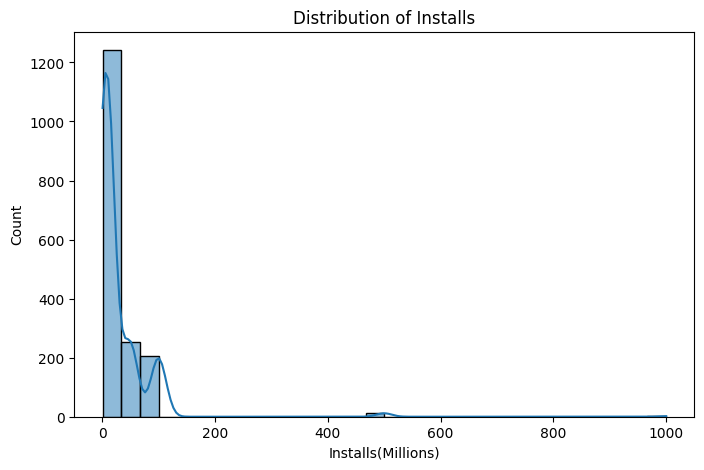

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(df['installs_numeric'] / 1e6, kde=True, bins=30)
plt.xlabel('Installs(Millions)')
plt.title('Distribution of Installs')
plt.show()
plt.savefig('installs_distribution.png')
plt.show()

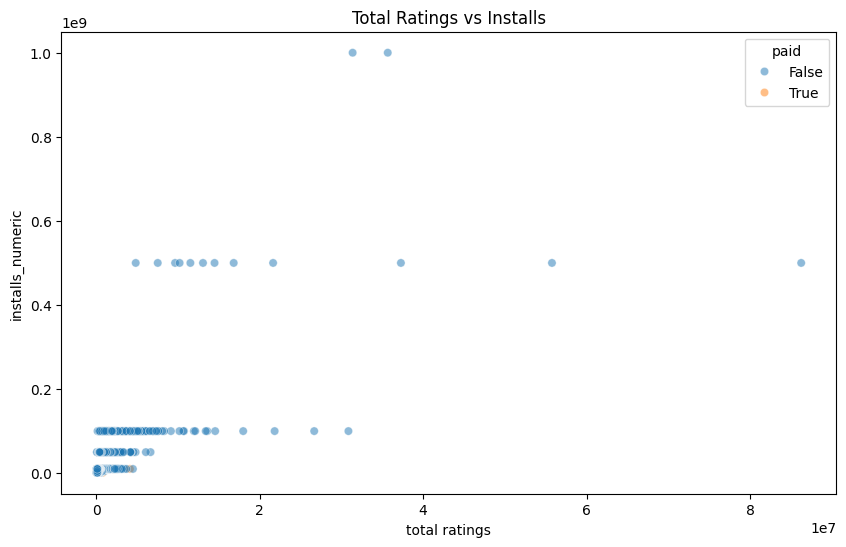

<Figure size 640x480 with 0 Axes>

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='total ratings', y='installs_numeric', alpha=0.5, hue='paid')
plt.title('Total Ratings vs Installs')
plt.show()
plt.savefig('ratings_vs_installs.png')

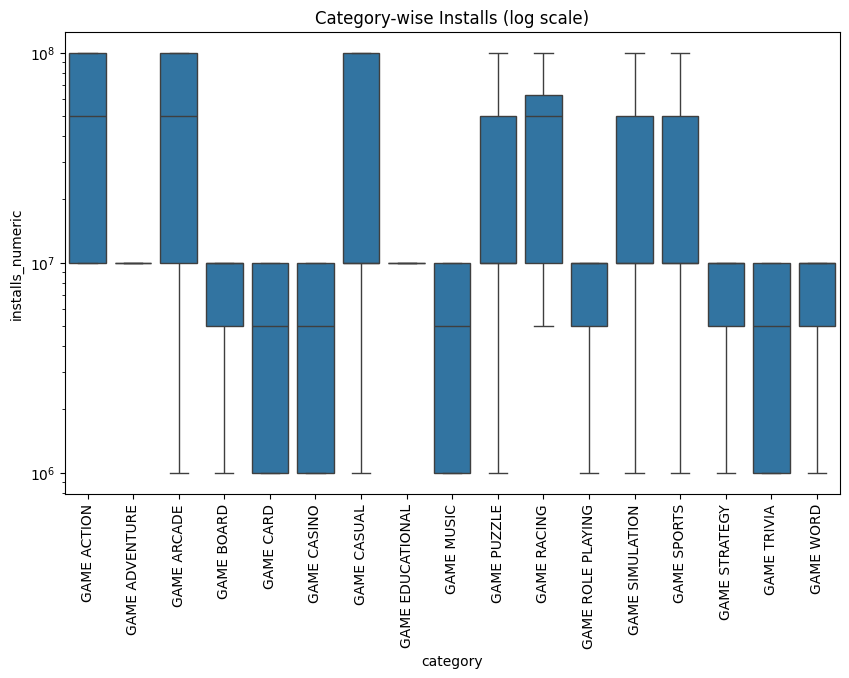

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='category', y='installs_numeric', showfliers=False)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Category-wise Installs (log scale)')
plt.show()
plt.savefig('category_installs_boxplot.png')

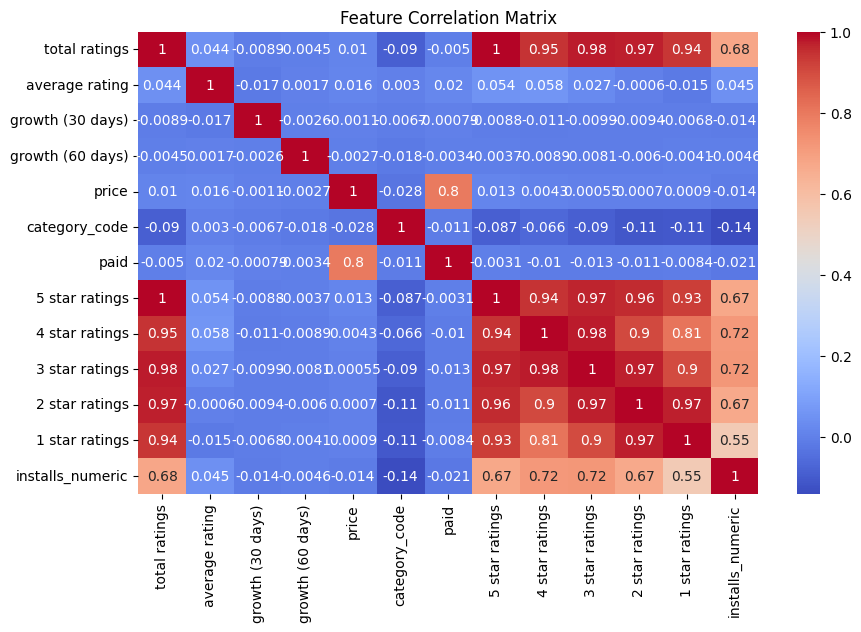

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(df[features + ['installs_numeric']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()
plt.savefig('feature_correlation_matrix.png')

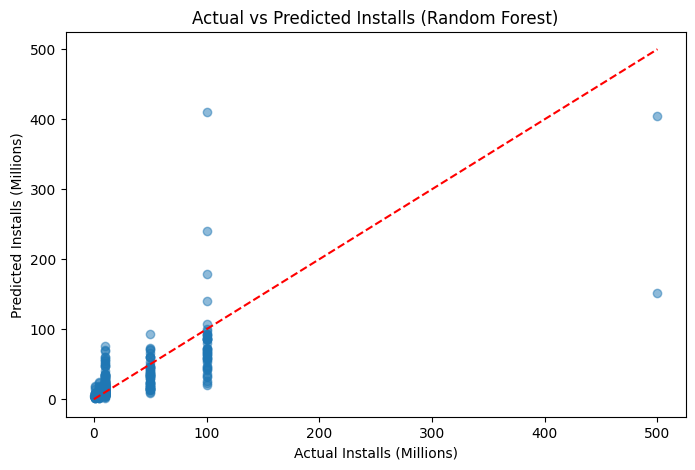

<Figure size 640x480 with 0 Axes>

In [18]:
plt.figure(figsize=(8,5))
plt.scatter(y_test/1e6, results['RandomForestRegressor']['y_pred']/1e6, alpha=0.5)
plt.xlabel('Actual Installs (Millions)')
plt.ylabel('Predicted Installs (Millions)')
plt.title('Actual vs Predicted Installs (Random Forest)')
plt.plot([0, max(y_test/1e6)], [0, max(y_test/1e6)], 'r--')
plt.show()
plt.savefig('actual_vs_predicted_installs.png')

In [20]:
predicted = results['RandomForestRegressor']['y_pred']
df_out = df.iloc[y_test.index].copy()
df_out['predicted_installs'] = predicted
df_out[['title', 'installs_numeric', 'predicted_installs']].to_csv('android_games_predicted.csv', index=False)
print('Predictions saved to android_games_predicted.csv')

Predictions saved to android_games_predicted.csv
